In [1]:
import pandas as pd
import cca_mixture
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt
%matplotlib inline

## Helper methods

In [2]:
def reduce_connectome(connectome):
    n_subjects = connectome.shape[0]
    group_ICA_dim = int(np.sqrt(connectome.shape[1]))
    reduced_connectome = np.zeros((n_subjects,group_ICA_dim*(group_ICA_dim-1)/2))
    upper_tri_indices = np.triu_indices(group_ICA_dim,k=1)
    for i in range(n_subjects):
        subject = np.reshape(connectome[i,:],(group_ICA_dim,group_ICA_dim))
        reduced_connectome[i,:] = subject[upper_tri_indices]
    return reduced_connectome

In [3]:
def get_treatment_nontreatment_groups(data):
    nontreatment = data[data['TreatmentGroup'] == 'Sham Exc+Sham cognitive']
    nontreatment_index = nontreatment.index.values
    
    treatment = data[data['TreatmentGroup'] != 'Sham Exc+Sham cognitive']
    treatment_index = treatment.index.values
    
    treatment_class = pd.get_dummies(data['TreatmentGroup'])
    
    return nontreatment_index, treatment_index, treatment_class

In [4]:
def plot_study_result(X,Y):
    zero_class = np.where(Y[:, 0])
    one_class = np.where(Y[:, 1])
    two_class = np.where(Y[:, 2])
    three_class = np.where(Y[:, 3])
    
    plt.scatter(X[:, 0], X[:, 1], s=40, c='gray')
    one= plt.scatter(X[zero_class, 0], X[zero_class, 1], s=160, edgecolors='b',
                   facecolors='none', linewidths=2, label='Class C+R_Sham')
    two = plt.scatter(X[one_class, 0], X[one_class, 1], s=80, edgecolors='orange',
                   facecolors='none', linewidths=2, label='Class R+C')
    three =plt.scatter(X[two_class, 0], X[two_class, 1], s=160, edgecolors='red',
                   facecolors='none', linewidths=2, label='Class R+C_Sham')
    four = plt.scatter(X[three_class, 0], X[three_class, 1], s=80, edgecolors='green',
                   facecolors='none', linewidths=2, label='Class Double Shammy')
    plt.legend(handles=[one,two,three,four])

# BL Data

In [5]:
BL_data = pd.read_excel('/home/hngu4068/Documents/SMART_STUDY/SMART_MasterDatabase_CCA.xlsx',sheetname = 1)
BL_data.head()

,TreatmentGroup,ParticipantStudyID,Ageyears,EducationYrs,TICSMScore_BL,TotalDrinksperweek_BL,TotalInformantBayerIADLscore_BL,ParticipantSubjectiveMemoryConcernTotalScore_BL,MMSETrial1UncorrectedScore_BL,MMSETrial1CorrectedScore_BL,...,rh_rostralmiddlefrontal_thickness,rh_superiorfrontal_thickness,rh_superiorparietal_thickness,rh_superiortemporal_thickness,rh_supramarginal_thickness,rh_frontalpole_thickness,rh_temporalpole_thickness,rh_transversetemporal_thickness,rh_insula_thickness,rh_MeanThickness_thickness
0,Sham Exc+Sham cognitive,2,70.59,19,21,0.000,1.160,2,28,30,...,2.195,2.565,1.961,2.491,2.238,2.276,3.588,1.884,2.836,2.27532
1,Resistance training+ Sham cognitive,3,65.62,19,27,7.000,1.231,5,27,27,...,2.297,2.570,1.981,2.609,2.259,2.496,3.097,2.132,2.634,2.31103
2,Cognitive training+Sham exc,4,78.96,14,16,0.000,1.217,3,29,30,...,2.085,2.456,2.070,2.472,2.180,2.216,3.462,2.499,2.650,2.22049
3,Resistance training + Cognitive training,6,65.70,14,24,7.000,1.269,3,28,28,...,2.335,2.689,2.170,2.645,2.461,2.818,3.097,2.495,2.748,2.39028
4,Resistance training+ Sham cognitive,7,70.92,20,24,0.000,2.680,4,27,27,...,2.438,2.594,2.305,2.688,2.458,2.484,3.384,2.452,2.743,2.48118


In [6]:
BL_treatment_no =np.zeros((BL_data.shape[0],1))
i = 0
for ele in BL_data['TreatmentGroup'].unique():
    double_sham = BL_data[BL_data['TreatmentGroup'] == ele]
    double_sham_index = double_sham.index.values
    BL_treatment_no[double_sham_index] = i
    i+=1

In [7]:
cog_headings = BL_data.columns.values
cog_headings = cog_headings[4:]
BL_neuro_scores = BL_data[cog_headings]
BL_neuro_scores = BL_neuro_scores.fillna(0)
BL_neuro_scores= BL_neuro_scores.replace('.', 0, regex=True)
BL_neuro_scores['TotalDrinksperweek_BL'] = pd.to_numeric(BL_neuro_scores['TotalDrinksperweek_BL'])
BL_neuro_scores.head()

,TICSMScore_BL,TotalDrinksperweek_BL,TotalInformantBayerIADLscore_BL,ParticipantSubjectiveMemoryConcernTotalScore_BL,MMSETrial1UncorrectedScore_BL,MMSETrial1CorrectedScore_BL,CDRSum_BL,SUMofmemorytrials_BL,ADASCOGTotalScore_BL,TrailmakingtestPartAtotaltimesec_BL,...,rh_rostralmiddlefrontal_thickness,rh_superiorfrontal_thickness,rh_superiorparietal_thickness,rh_superiortemporal_thickness,rh_supramarginal_thickness,rh_frontalpole_thickness,rh_temporalpole_thickness,rh_transversetemporal_thickness,rh_insula_thickness,rh_MeanThickness_thickness
0,21,0,1.160,2,28,30,0.0,22,10.6,37,...,2.195,2.565,1.961,2.491,2.238,2.276,3.588,1.884,2.836,2.27532
1,27,0,1.231,5,27,27,1.0,22,10.9,27,...,2.297,2.570,1.981,2.609,2.259,2.496,3.097,2.132,2.634,2.31103
2,16,0,1.217,3,29,30,0.5,13,11.9,43,...,2.085,2.456,2.070,2.472,2.180,2.216,3.462,2.499,2.650,2.22049
3,24,0,1.269,3,28,28,0.5,27,4.3,27,...,2.335,2.689,2.170,2.645,2.461,2.818,3.097,2.495,2.748,2.39028
4,24,0,2.680,4,27,27,0.5,20,12.9,26,...,2.438,2.594,2.305,2.688,2.458,2.484,3.384,2.452,2.743,2.48118


In [8]:
BL_connectome = np.loadtxt('/home/hngu4068/Documents/SMART_STUDY/NET_BL.txt')

In [9]:
#scale our data
BL_neuro_scores_scale = minmax_scale(BL_neuro_scores)
reduced_BL_connectome = reduce_connectome(BL_connectome)
BL_connectome_normalize = normalize(reduced_BL_connectome)

# do a pca reduction
from sklearn.decomposition import PCA
pca = PCA(n_components = 20)
BL_connectome_normalize = pca.fit_transform(BL_connectome_normalize)
BL_neuro_scores_scale = pca.fit_transform(BL_neuro_scores_scale)


In [10]:
cca = cca_mixture.CCA_Mixture(BL_neuro_scores_scale,BL_connectome_normalize,n_mixtures = 4,n_epochs=7000,
                              starter_learning_rate=0.2,learning_rate_decay=0.9,learning_rate_step_decrease = 100,print_step =500)
cca.train()
BL_latent = cca.transform()

loss is -449.97
loss is -645.29
loss is -1395.22
loss is -1429.55
loss is -353.85
loss is -491.04
loss is -668.21
loss is -392.99
loss is -395.18
loss is -315.65
loss is -453.15
loss is -279.90
loss is -408.92
loss is -352.59


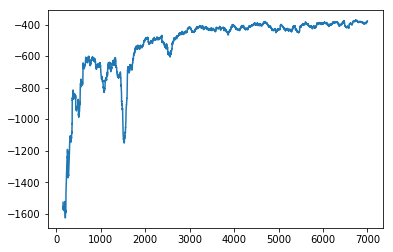

In [11]:
n_epoch = cca.n_epochs
moving_avg = np.zeros(n_epoch-150)
for i  in range(n_epoch-150):
    moving_avg[i] = np.mean(cca.avg_loss_array[i:i+100])
plt.plot(range(150,n_epoch),moving_avg)

In [12]:
BL_nontreatment_index, BL_treatment_index, BL_treatment_class = get_treatment_nontreatment_groups(BL_data)
BL_treatment_study_latent = BL_latent[BL_treatment_index,:]
BL_nontreatment_study_latent = BL_latent[BL_nontreatment_index,:]

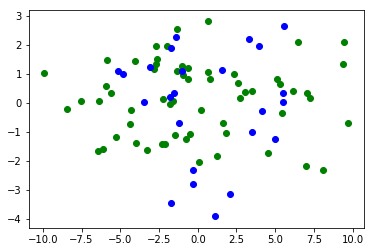

In [13]:
one = plt.scatter(BL_treatment_study_latent[:,0],BL_treatment_study_latent[:,1],color = 'green',label='Treatment')
two = plt.scatter(BL_nontreatment_study_latent[:,0],BL_nontreatment_study_latent[:,1],color = 'blue',label='Nontreatment')

In [14]:
treatment_class = pd.get_dummies(BL_data['TreatmentGroup'])

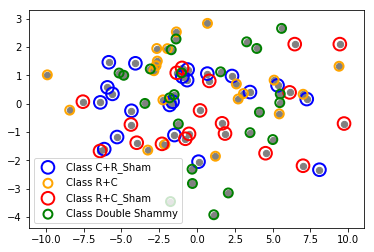

In [15]:
plot_study_result(BL_latent,treatment_class.values)

## FU1

In [16]:
FU1_data = pd.read_excel('/home/hngu4068/Documents/SMART_STUDY/SMART_MasterDatabase_CCA.xlsx',sheetname = 2)
FU1_data.head()

,TreatmentGroup,ParticipantStudyID,Ageyears,EducationYrs,TotalInformantBayerIADLscore_612,ParticipantSubjectiveMemoryConcernTotalScore_612,CDRSum_612,SUMofmemorytrials_612,ADASCOGTotalScore_612,MMSEUncorrectedScore_612,...,rh_rostralmiddlefrontal_thickness,rh_superiorfrontal_thickness,rh_superiorparietal_thickness,rh_superiortemporal_thickness,rh_supramarginal_thickness,rh_frontalpole_thickness,rh_temporalpole_thickness,rh_transversetemporal_thickness,rh_insula_thickness,rh_MeanThickness_thickness
0,Sham Exc+Sham cognitive,2,70.59,19,1.115,.,2.0,17.0,12.0,.,...,2.197,2.599,1.944,2.459,2.219,2.262,3.581,1.883,2.790,2.27350
1,Resistance training+ Sham cognitive,3,65.62,19,1.153,.,0.5,23.0,6.6,.,...,2.341,2.607,2.002,2.680,2.302,2.655,3.291,2.285,2.738,2.36391
2,Cognitive training+Sham exc,4,78.96,14,1.000,.,4.5,15.0,15.3,.,...,2.357,2.546,2.008,2.671,2.374,2.507,3.827,2.376,2.887,2.37256
3,Resistance training + Cognitive training,6,65.70,14,1.346,.,0.0,24.0,6.0,.,...,2.205,2.503,2.193,2.642,2.519,2.320,3.375,2.449,2.868,2.33653
4,Resistance training+ Sham cognitive,7,70.92,20,3.615,.,0.0,24.0,6.6,.,...,2.250,2.765,2.202,2.619,2.484,2.509,3.248,2.189,2.680,2.42852


In [17]:
nontreatment_group = FU1_data[FU1_data['TreatmentGroup'] == 'Sham Exc+Sham cognitive']
nontreatment_group_index = nontreatment_group.index.values

treatment_group = FU1_data[FU1_data['TreatmentGroup'] != 'Sham Exc+Sham cognitive']
treatment_group_index = treatment_group.index.values

FU1_treatment_class = pd.get_dummies(FU1_data['TreatmentGroup'])

In [18]:
FU1_cog_headings = FU1_data.columns.values
FU1_cog_headings = FU1_cog_headings[4:]
FU1_neuro_scores = FU1_data[FU1_cog_headings]
FU1_neuro_scores = FU1_neuro_scores.fillna(0)
FU1_neuro_scores= FU1_neuro_scores.replace('.', 0, regex=True)
FU1_neuro_scores.head()

,TotalInformantBayerIADLscore_612,ParticipantSubjectiveMemoryConcernTotalScore_612,CDRSum_612,SUMofmemorytrials_612,ADASCOGTotalScore_612,MMSEUncorrectedScore_612,TrailmakingtestPartAtotaltimesec_612,TrailmakingtestPartBtotaltimesec_612,WAISMatricesTotalScore_612,WAISSimilaritiesTotalScore_612,...,rh_rostralmiddlefrontal_thickness,rh_superiorfrontal_thickness,rh_superiorparietal_thickness,rh_superiortemporal_thickness,rh_supramarginal_thickness,rh_frontalpole_thickness,rh_temporalpole_thickness,rh_transversetemporal_thickness,rh_insula_thickness,rh_MeanThickness_thickness
0,1.115,0,2.0,17.0,12.0,0,39,0,7,16,...,2.197,2.599,1.944,2.459,2.219,2.262,3.581,1.883,2.790,2.27350
1,1.153,0,0.5,23.0,6.6,0,37,0,19,30,...,2.341,2.607,2.002,2.680,2.302,2.655,3.291,2.285,2.738,2.36391
2,1.000,0,4.5,15.0,15.3,0,48,0,5,11,...,2.357,2.546,2.008,2.671,2.374,2.507,3.827,2.376,2.887,2.37256
3,1.346,0,0.0,24.0,6.0,0,33,0,22,24,...,2.205,2.503,2.193,2.642,2.519,2.320,3.375,2.449,2.868,2.33653
4,3.615,0,0.0,24.0,6.6,0,39,0,17,25,...,2.250,2.765,2.202,2.619,2.484,2.509,3.248,2.189,2.680,2.42852


In [19]:
FU1_neuro_scores = FU1_neuro_scores.as_matrix()
FU1_neuro_treatment = minmax_scale(FU1_neuro_scores[treatment_group_index,:])
FU1_neuro_nontreatment = minmax_scale(FU1_neuro_scores[nontreatment_group_index,:])

In [20]:
pca = PCA(n_components = 15)
FU1_neuro_treatment = pca.fit_transform(FU1_neuro_treatment)

In [21]:
FU1_connectome = np.loadtxt('/home/hngu4068/Documents/SMART_STUDY/NET_FU1.txt')
FU1_connectome_reduced = reduce_connectome(FU1_connectome)

FU1_connectome_treatment = normalize(FU1_connectome_reduced[treatment_group_index,:])
FU1_connectome_nontreatment = normalize(FU1_connectome_reduced[nontreatment_group_index,:])

FU1_connectome_treatment = pca.fit_transform(FU1_connectome_treatment)
FU1_connectome_nontreatment = pca.fit_transform(FU1_connectome_nontreatment)

loss is -212.77
loss is -573.42
loss is -804.27
loss is -322.15
loss is -451.55
loss is -405.24


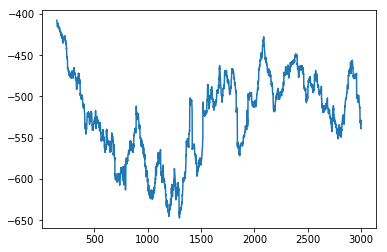

In [22]:
FU1_treatment_cca = cca_mixture.CCA_Mixture(FU1_neuro_treatment,FU1_connectome_treatment,n_mixtures = 4,n_epochs=3000,
                              starter_learning_rate=0.15,learning_rate_decay=0.7,learning_rate_step_decrease = 100,print_step =500)
FU1_treatment_cca.train()
FU1_treatment_latent = FU1_treatment_cca.transform()

n_epoch = FU1_treatment_cca.n_epochs
moving_avg = np.zeros(n_epoch-150)
for i  in range(n_epoch-150):
    moving_avg[i] = np.mean(FU1_treatment_cca.avg_loss_array[i:i+100])
plt.plot(range(150,n_epoch),moving_avg)

loss is -81.45
loss is -103.32
loss is -91.16
loss is -81.05
loss is -74.60
loss is -69.67


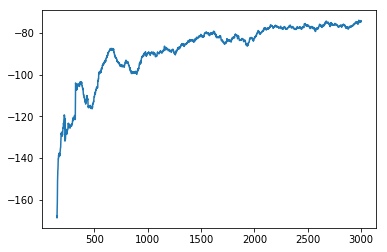

In [23]:
pca = PCA(n_components = 5)
FU1_neuro_nontreatment = pca.fit_transform(FU1_neuro_nontreatment)
FU1_connectome_nontreatment = pca.fit_transform(FU1_connectome_nontreatment)

FU1_nontreatment_cca = cca_mixture.CCA_Mixture(FU1_neuro_nontreatment,FU1_connectome_nontreatment,n_mixtures = 1,n_epochs=3000,
                              starter_learning_rate=0.9,learning_rate_decay=0.6,learning_rate_step_decrease = 100,print_step =500)
FU1_nontreatment_cca.train()
FU1_nontreatment_latent = FU1_nontreatment_cca.transform()

n_epoch = FU1_nontreatment_cca.n_epochs
moving_avg = np.zeros(n_epoch-150)
for i  in range(n_epoch-150):
    moving_avg[i] = np.mean(FU1_nontreatment_cca.avg_loss_array[i:i+100])
plt.plot(range(150,n_epoch),moving_avg)

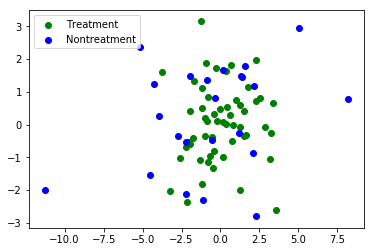

In [24]:
one = plt.scatter(FU1_treatment_latent[:,0],FU1_treatment_latent[:,1],color = 'green',label='Treatment')
two = plt.scatter(FU1_nontreatment_latent[:,0],FU1_nontreatment_latent[:,1],color = 'blue',label='Nontreatment')
plt.legend(handles=[one,two])

loss is -304.83
loss is -2228.60
loss is -1046.85
loss is -8694.57
loss is -1515.39
loss is -1100.00
loss is -4815.88
loss is -1708.29
loss is -83645.94
loss is -1449.15
loss is -2040.62
loss is -1282.23
loss is -534.54
loss is -703.10
loss is -808.38
loss is -945.69
loss is -3006.13
loss is -21125.34
loss is -1128.82
loss is -699.92
loss is -1874.64
loss is -888.39
loss is -862.18
loss is -631.29
loss is -602.23
loss is -765.92
loss is -1538.96
loss is -927.70
loss is -722.63
loss is -690.39
loss is -918.09
loss is -670.42
loss is -688.25
loss is -2141.98
loss is -1667.81
loss is -787.21
loss is -2127.94
loss is -691.58
loss is -718.55
loss is -684.08
loss is -23162.51
loss is -868.29
loss is -1020.61
loss is -1803.42
loss is -676.64
loss is -3979.72
loss is -1668.71
loss is -981.40
loss is -2637.17
loss is -1139.83
loss is -5993.51
loss is -5523.99
loss is -5790.97
loss is -1667.66
loss is -366948.52
loss is -4004.56
loss is -12859.61
loss is -3043.17
loss is -1148.59
loss is -899.53

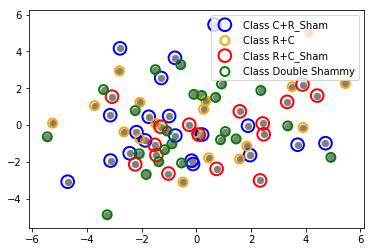

In [28]:
#do analysis all together
pca = PCA(n_components = 20)
FU1_neuro_scale = minmax_scale(FU1_neuro_scores)
FU1_connectome_normalized = normalize(FU1_connectome_reduced)

FU1_neuro_pca = pca.fit_transform(FU1_neuro_scale)
FU1_connectome_pca = pca.fit_transform(FU1_connectome_normalized)
                                                                          
FU1_cca = cca_mixture.CCA_Mixture(FU1_neuro_pca,FU1_connectome_pca,n_mixtures = 4,n_epochs=1000,
                              starter_learning_rate=0.9,learning_rate_decay=0.6,learning_rate_step_decrease = 100,print_step =1)
FU1_cca.train()
FU1_latent = FU1_cca.transform()
plot_study_result(FU1_latent,FU1_treatment_class.values)

In [33]:
FU1_classes = FU1_cca.get_mixture_assignments()
transformed_sigma = FU1_cca.session.run(FU1_cca.qt_sigma)
N = FU1_classes.shape[0]
latents_sigma = np.zeros((N,2,2))
for i in range(N):
    latents_sigma[i] = transformed_sigma[FU1_classes[i],i,:]

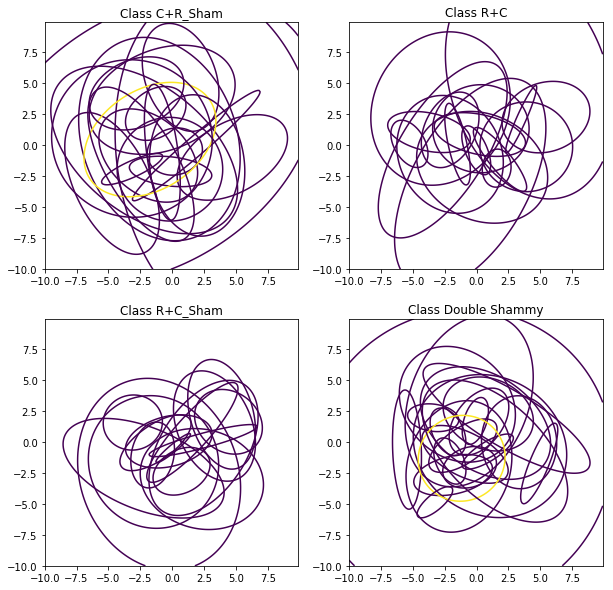

In [82]:
from scipy.stats import multivariate_normal
x, y = np.mgrid[-10:10:.1, -10:10:.1]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y

fig = plt.figure(figsize=(10, 10)) 
n_lines = 1
for i in range(FU1_latent.shape[0]):
    if np.argmax(FU1_treatment_class.values[i]) == 0:
        rv = multivariate_normal(FU1_latent[i,:], np.dot(latents_sigma[i,:,:],latents_sigma[i,:,:].T))
        ax1 = plt.subplot(2,2,1)
        ax1.contour(x, y, rv.pdf(pos),n_lines,c = 'blue')
        plt.title('Class C+R_Sham')
    elif np.argmax(FU1_treatment_class.values[i]) == 1:
        rv = multivariate_normal(FU1_latent[i,:], np.dot(latents_sigma[i,:,:],latents_sigma[i,:,:].T))
        ax2 = plt.subplot(2,2,2)
        ax2.contour(x, y, rv.pdf(pos),n_lines,c = 'green')
        plt.title('Class R+C')
    elif np.argmax(FU1_treatment_class.values[i]) == 2:
        rv = multivariate_normal(FU1_latent[i,:], np.dot(latents_sigma[i,:,:],latents_sigma[i,:,:].T))
        ax3 = plt.subplot(2,2,3)
        ax3.contour(x, y, rv.pdf(pos),n_lines,c = 'red')
        plt.title('Class R+C_Sham')
    else:
        rv = multivariate_normal(FU1_latent[i,:], np.dot(latents_sigma[i,:,:],latents_sigma[i,:,:].T))
        ax4 = plt.subplot(2,2,4)
        ax4.contour(x, y, rv.pdf(pos),n_lines,c = 'purple')
        plt.title('Class Double Shammy')